In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [3]:
os.chdir('data/ON_Ptax')

In [4]:
files=os.listdir()

In [5]:
excel_files = [file for file in files if '.xlsx' in file]

In [6]:
excel_files

['VIEWFIR2011-22.xlsx',
 'VIEWFIR2012-22.xlsx',
 'VIEWFIR2013-22.xlsx',
 'VIEWFIR2014-22.xlsx',
 'VIEWFIR2015-22.xlsx',
 'VIEWFIR2016-22.xlsx',
 'VIEWFIR2017-22.xlsx',
 'VIEWFIR2018-22.xlsx',
 'VIEWFIR2019-22.xlsx',
 'VIEWFIR2020-22.xlsx',
 'VIEWFIR2021-22.xlsx']

In [7]:
def df_from_excelFiles(file_name):
    file = pd.ExcelFile(file_name)
    name='SCHEDULE 22GPL'
    return file.parse(name, skiprows=4)

In [8]:
ptax_frame = pd.concat([df_from_excelFiles(xl) for xl in excel_files])

In [9]:
# Note for the years 2010-09, 2008-2000 I need to come up with different df_excelFiles functions to handle slight differences in the files.  I will then concat the three dataframes.
ptax_frame['Year'].value_counts()

2020    8296
2019    8138
2018    8046
2017    8000
2016    7920
2021    7888
2015    7720
2014    7693
2013    7566
2012    7126
2011    6993
Name: Year, dtype: int64

In [10]:
ptax_frame.drop(columns=['Unnamed: 0'], inplace=True)

In [11]:
ptax_frame.rename(columns={'LT/ST\nTax Rate':'LtSt_TaxRate', 'UT\nTax Rate':'Ut_Rate', 'EDUC\nTax Rate':'Education_Rate', 'TOTAL\nTax Rate':'Total_TaxRate'}, inplace=True)

In [12]:
ptax_frame.loc[ptax_frame['Municipality'] == 'Markham T', 'Municipality'] = 'Markham C'

In [13]:
Durham = ['Durham R','Ajax T', 'Clarington M', 'Brock Tp', 'Oshawa C', 'Pickering C', 'Scugog Tp', 'Uxbridge Tp', 'Whitby T']
Halton = ['Halton R', 'Burlington C', 'Halton Hills T', 'Milton T', 'Oakville T']
Peel = ['Peel R', 'Brampton C', 'Mississauga C', 'Caledon T']
York = ['York R', 'Vaughan C', 'Markham C', 'Richmond Hill C', 'Aurora T', 'Newmarket T', 'Whitchurch-Stouffville T', 'East Gwillimbury T', 'Georgina T', 'King Tp']
Dufferin = ['Mono T', 'Orangeville T']
Simcoe = ['Bradford West Gwillimbury T', 'New Tecumseth T']
Toronto = ['Toronto C']

In [14]:
GTA = Durham + Halton + Peel + York + Dufferin + Simcoe + Toronto

In [15]:
gta_ptax_frame = ptax_frame[ptax_frame['Municipality'].isin(GTA)]

In [16]:
pclasses = ['Residential', 'Commercial', 'Industrial', 'Large Industrial', 'Multi-Residential', 'Farmland', 'Managed Forest', 'Pipeline']

In [17]:
gta_ptax_frame = gta_ptax_frame[(gta_ptax_frame['Property Class'].isin(pclasses)) & (gta_ptax_frame['Tax Rate Description'] == 'Full Occupied')].copy()

In [18]:
upper_tier = ['York R', 'Halton R', 'Peel R', 'Durham R']

In [19]:
gta_sL_ptax= gta_ptax_frame[~gta_ptax_frame.Municipality.isin(upper_tier)]
gta_sL_ptax.loc[gta_sL_ptax['Municipality'].isin(Durham),['Region']] = 'Durham R'
gta_sL_ptax.loc[gta_sL_ptax['Municipality'].isin(York),['Region']] = 'York R'
gta_sL_ptax.loc[gta_sL_ptax['Municipality'].isin(Peel),['Region']] = 'Peel R'
gta_sL_ptax.loc[gta_sL_ptax['Municipality'].isin(Halton),['Region']] = 'Halton R'
gta_sL_ptax.loc[gta_sL_ptax['Municipality'].isin(Dufferin),['Region']] = 'Dufferin Co'
gta_sL_ptax.loc[gta_sL_ptax['Municipality'].isin(Simcoe),['Region']] = 'Simcoe Co'
gta_sL_ptax.loc[gta_sL_ptax['Municipality'].isin(Toronto),['Region']] = 'Toronto C'

In [20]:
gta_sL_ptax.columns

Index(['Year', 'Asmt Code', 'Municipality', 'MAH Code', 'MunID', 'UT', 'Tier',
       'MSO', 'Line', 'Levy Area', '22 Levy Area Name', 'RTC/RTQ', 'Tax\nBand',
       'Property Class', 'Tax Rate Description', 'Tax Ratio', '% Full Rate',
       'CVA Assessment', 'Phase-In Taxable Assessment', 'LtSt_TaxRate',
       'Ut_Rate', 'Education_Rate', 'Total_TaxRate', 'LT/ST\nTaxes',
       'UT\nTaxes', 'EDUC\nTaxes', 'TOTAL\nTaxes', 'Last Update', 'Region'],
      dtype='object')

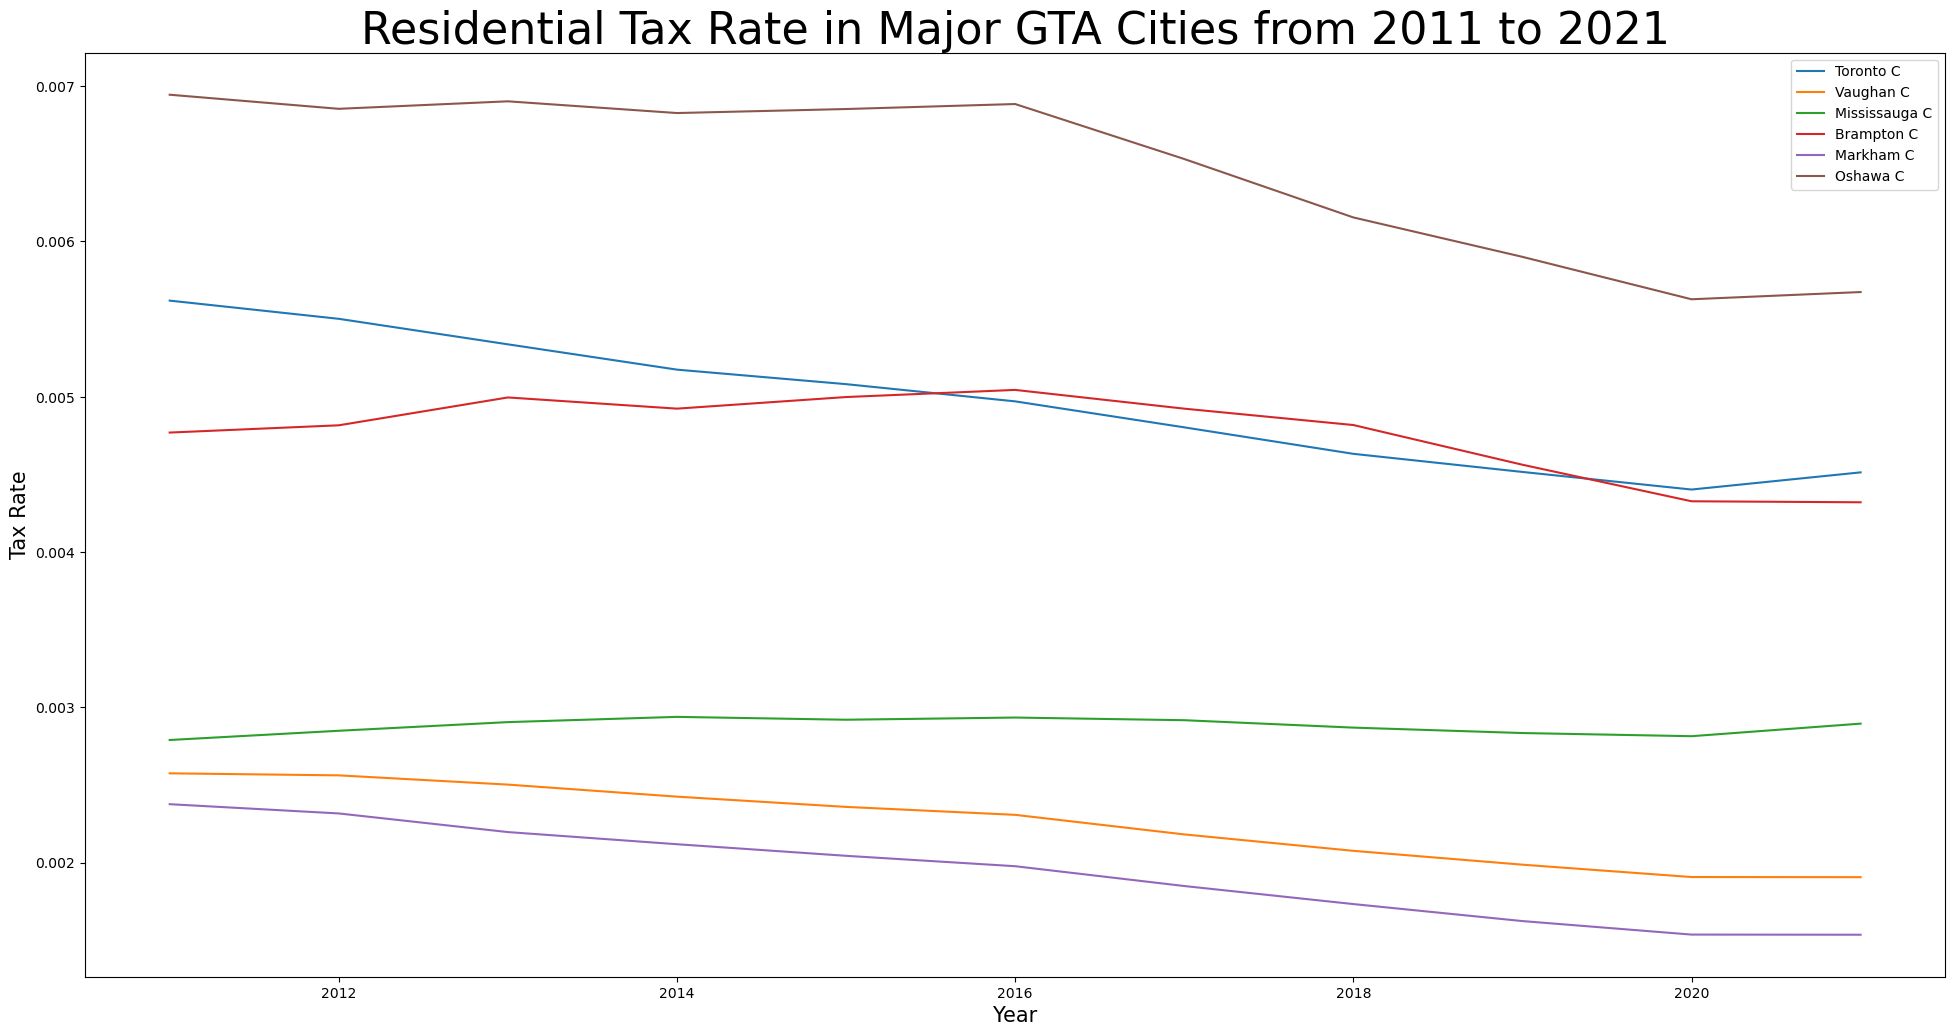

In [21]:
cities = ['Toronto C', 'Vaughan C', 'Mississauga C', 'Brampton C', 'Markham C', 'Oshawa C']
data = gta_sL_ptax[(gta_sL_ptax['Municipality'].isin(cities)) & (gta_sL_ptax['Property Class'] == 'Residential')]
plt.figure(figsize=(24,12))
for city in cities:
    plt.plot(data[data['Municipality'] == city]['Year'], data[data['Municipality'] == city]['LtSt_TaxRate'], label=city)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Tax Rate', fontsize=15)
plt.title('Residential Tax Rate in Major GTA Cities from 2011 to 2021', fontsize=32)
plt.legend()
plt.show()

This is very interesting.  The above chart seems very counter intuitive.  It shows that property taxation rates for the Residential property class has tended to decline in most of the large cities in the GTA.  How can this be?  Are we not constantly hearing that property taxes are going up?

Using the example of Toronto, the chart below tries to make sense of this puzzle.

In [22]:
data = gta_sL_ptax[(gta_sL_ptax['Municipality'] == 'Toronto C') & (gta_sL_ptax['Property Class'] == 'Residential')][['Year','CVA Assessment',      'Phase-In Taxable Assessment','LtSt_TaxRate','Education_Rate', 'Total_TaxRate', 'LT/ST\nTaxes', 'EDUC\nTaxes', 'TOTAL\nTaxes']]

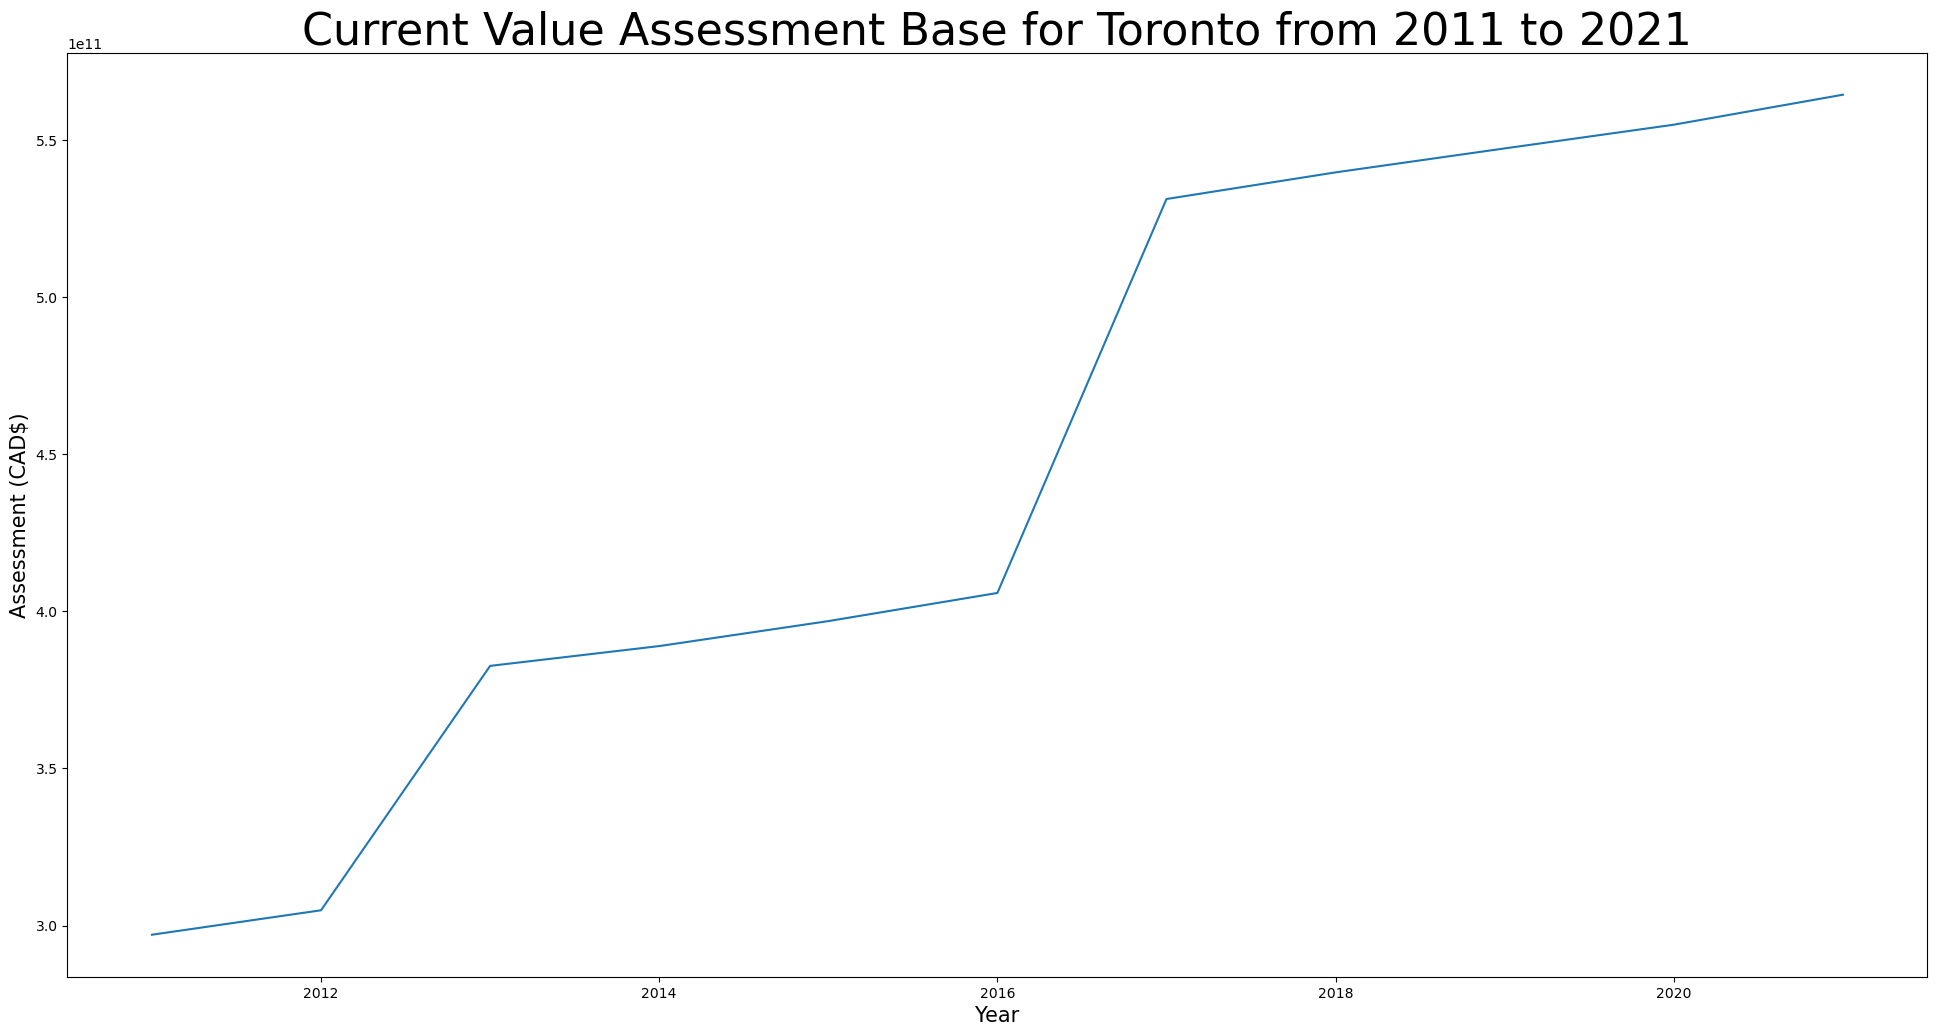

In [23]:
data = gta_sL_ptax[(gta_sL_ptax['Municipality'] == 'Toronto C') & (gta_sL_ptax['Property Class'] == 'Residential')][['Year','CVA Assessment',      'Phase-In Taxable Assessment','LtSt_TaxRate','Education_Rate', 'Total_TaxRate', 'LT/ST\nTaxes', 'EDUC\nTaxes', 'TOTAL\nTaxes']]

plt.figure(figsize=(24,12))
plt.plot(data['Year'], data['CVA Assessment'])
plt.xlabel('Year', fontsize=15)
plt.ylabel('Assessment (CAD$)', fontsize=15)
plt.title('Current Value Assessment Base for Toronto from 2011 to 2021', fontsize=32)
plt.show()

In the chart above we can see that the assessment base for Toronto has grown at a rapid rate from 2011 to 2012.  What this show is that the increase in property taxes that people experience can be attributed to the increase in property prices.  Municipalities set their tax rates in response to two key elements - 1. the total expected costs for the year 2. the total value of the assessment base.  Given the fact that property prices are pushing upward, it seems that there has been a trend for municipal tax rates in the residential class to decline.

One should note that there are large increases in the tax base in 2012 and 2016 respectively followed by periods of more gradual growth.  These large jumps are due to province-wide MPAC property assessments that are done on a 4-year schedule.  Due to the COVID-19 pandemic the MPAC assessment scheduled for 2020 has been postponed.

(add different perspectives on return to assessment cycle)

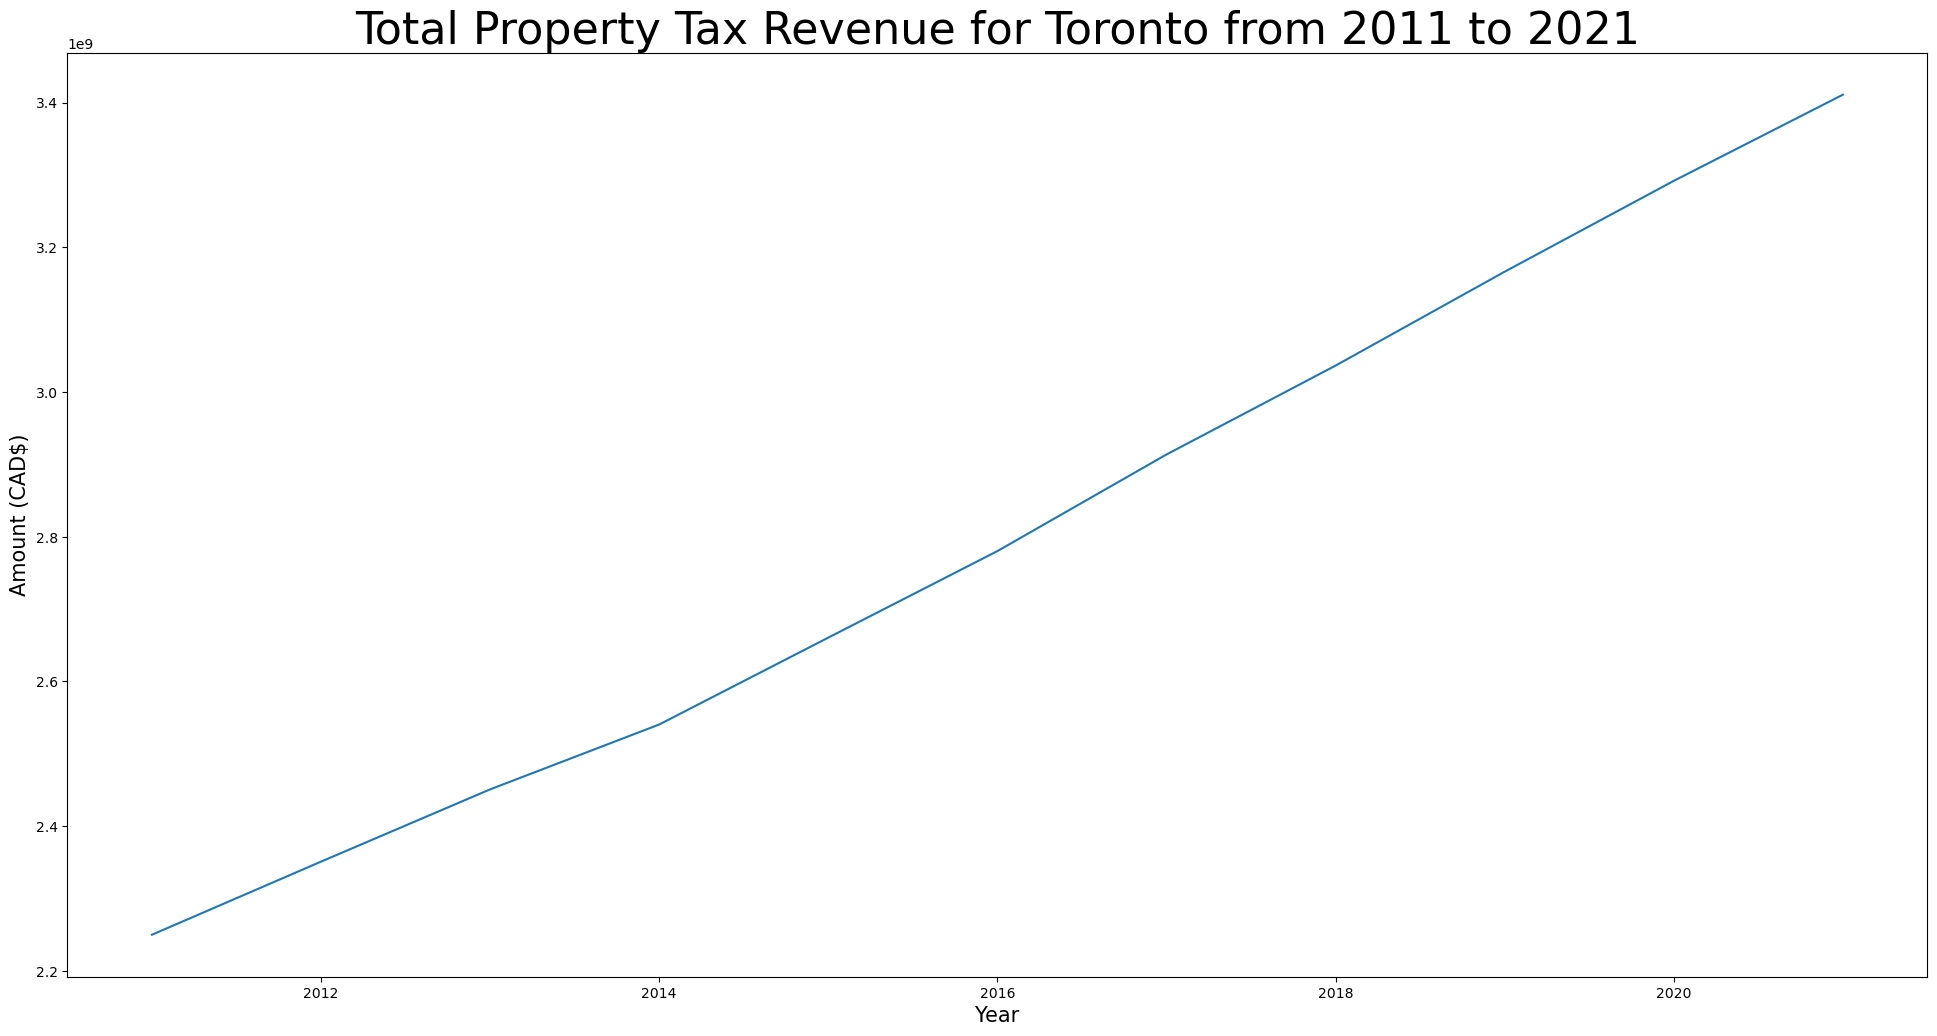

In [24]:
data = gta_sL_ptax[(gta_sL_ptax['Municipality'] == 'Toronto C') & (gta_sL_ptax['Property Class'] == 'Residential')][['Year','CVA Assessment',      'Phase-In Taxable Assessment','LtSt_TaxRate','Education_Rate', 'Total_TaxRate', 'LT/ST\nTaxes', 'EDUC\nTaxes', 'TOTAL\nTaxes']]
plt.figure(figsize=(24,12))
plt.plot(data['Year'], data['TOTAL\nTaxes'])
plt.xlabel('Year', fontsize=15)
plt.ylabel('Amount (CAD$)', fontsize=15)
plt.title('Total Property Tax Revenue for Toronto from 2011 to 2021', fontsize=32)
plt.show()

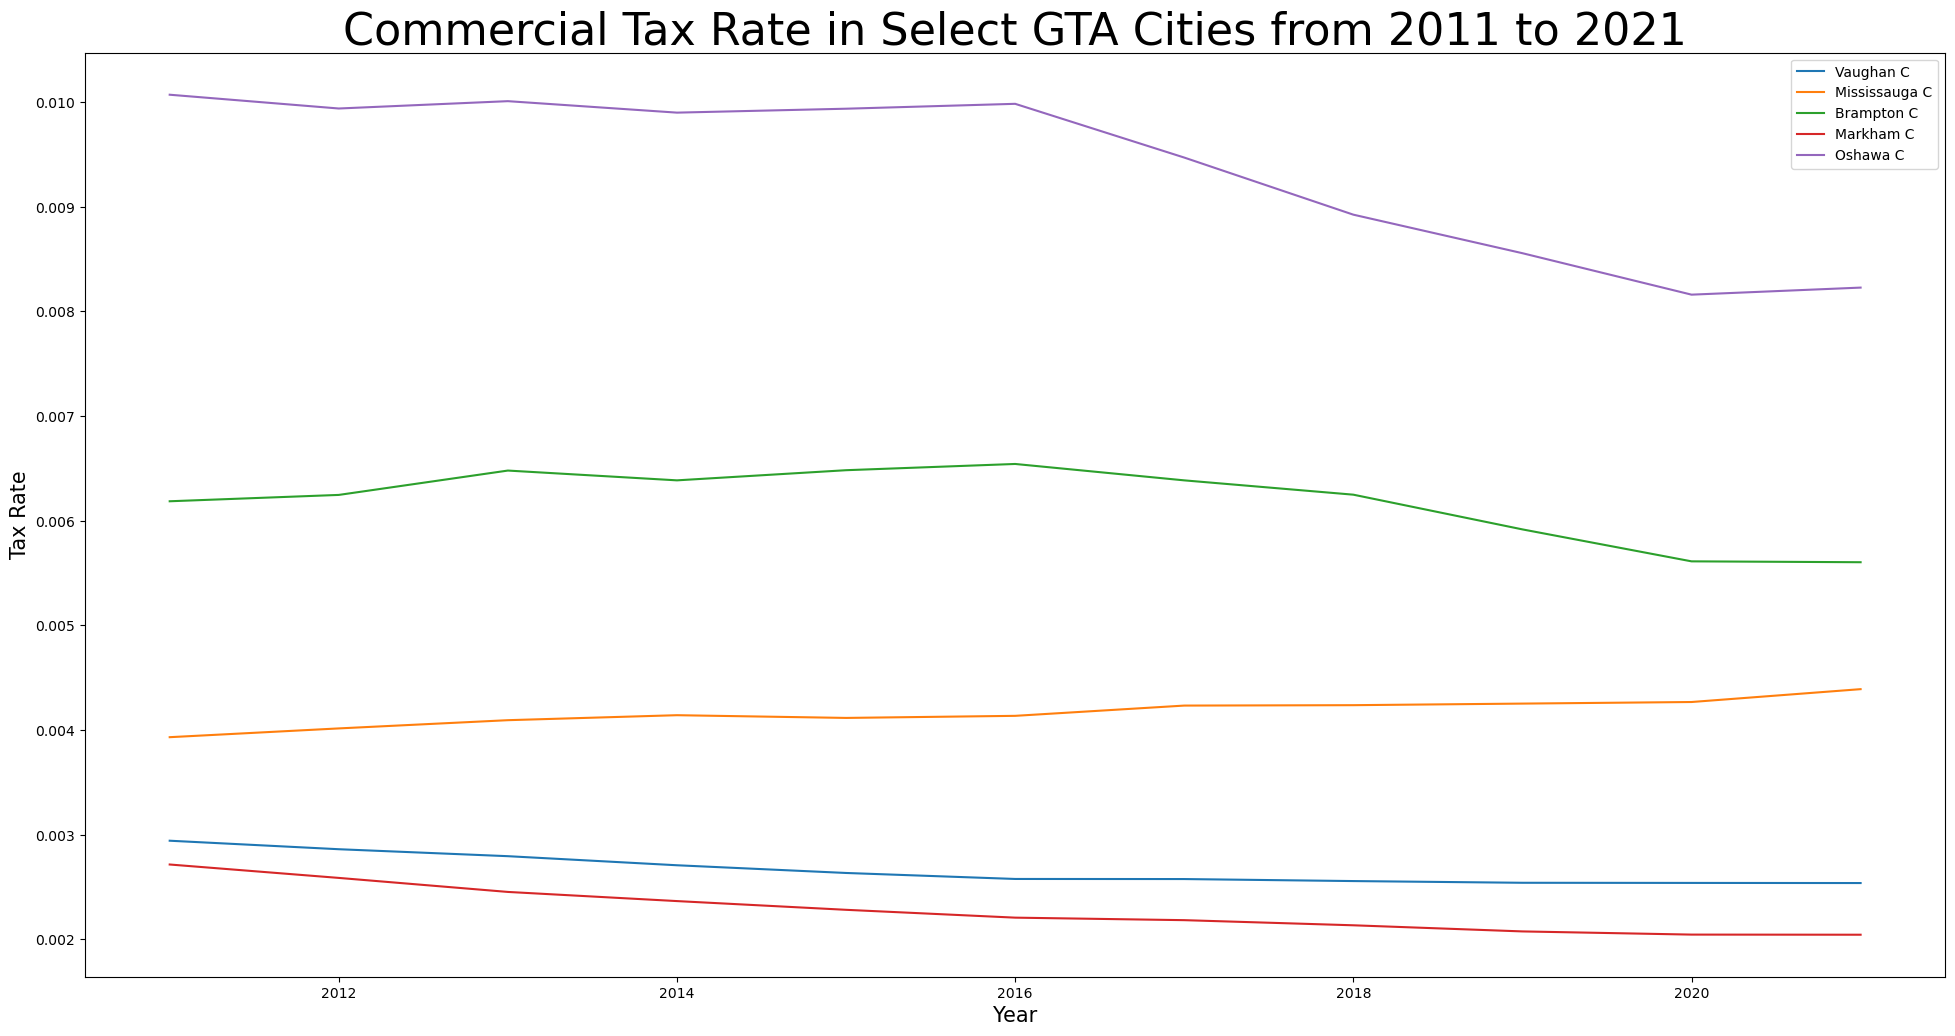

In [25]:
# Note I had to exclude Toronto here for the time being as its banded Commercial Tax rate (2 rates) messes up the visualization
cities = ['Vaughan C', 'Mississauga C', 'Brampton C', 'Markham C', 'Oshawa C']
data = gta_sL_ptax[(gta_sL_ptax['Municipality'].isin(cities)) & (gta_sL_ptax['Property Class'] == 'Commercial')]
plt.figure(figsize=(24,12))
for city in cities:
    plt.plot(data[data['Municipality'] == city]['Year'], data[data['Municipality'] == city]['LtSt_TaxRate'], label=city)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Tax Rate', fontsize=15)
plt.title('Commercial Tax Rate in Select GTA Cities from 2011 to 2021', fontsize=32)
plt.legend()
plt.show()